<a href="https://colab.research.google.com/github/vl0/ML-Deep-Learning/blob/main/nlp_model_comperison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# In this notebook, 6 models for NLP are compared
# The simplest model, used as a benchmark, is the multinomial naivse bayers
# Other models are 
# The dataset being analysed is the "R"eal Or Not?" dataset originaly published on Kaggle

In [ ]:
# Helper funtion 1
# Function to evaluate accuracy, precision, recall, f1-score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Helper function 2 
# compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

In [ ]:
# Getting dataset

import zipfile
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

zip_ref = zipfile.ZipFile("nlp_getting_started.zip", "r")
zip_ref.extractall()
zip_ref.close()


--2023-01-18 08:51:41--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.009s  

2023-01-18 08:51:41 (61.0 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
# Creating dataframes from imported CVS files
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe (not necessery)

train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# Dataset exploration - information about train and test datasets

print("Number of train instances:")
print(len(train_df))

print("Number of test instances:")
print(len(test_df))

Number of train instances:
7613
Number of test instances:
3263


In [ ]:
# Dataset exploration - show 
import random
random_index=random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
Breaking news: Haunting memories drawn by survivors http://t.co/PCjBvrs7xw

---

Target: 1 (real disaster)
Text:
Reminder: Mass murderer and white supremacist Anders Breivik was also unsurprisingly an anti-feminist.
http://t.co/1lXnJVl8TR

---

Target: 0 (not real disaster)
Text:
do he love me do he love me not I ain't a playa I just crush a lot

---

Target: 1 (real disaster)
Text:
Julian Knight - @SCVSupremeCourt dismisses mass murderer's attempt to increase prisoner pay. Challenged quantum of 5% increase 2013.

---

Target: 1 (real disaster)
Text:
Savings and sewing in Guatemala: Savings and sewing in Guatemala. When a natural disaster hit seamstress Elvia...  http://t.co/jdx9OX2kIk

---



In [ ]:
# Split train data into train and validation datasets
# Train data
# Validation data 

from sklearn.model_selection import train_test_split 

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, #10/90 split, test=validation
                                                                            random_state=42)

In [ ]:
# Average number of words in training tweets
round((sum(len(i.split()) for i in train_sentences))/len(train_sentences))

15

In [ ]:
# Text vectorisation
# Convert text into numbers

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_vocab_length=1000 #max number of words in vocab
max_length=15 # How many words from every instance (tweet) does the model see

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, # n words in vocab
                                    standardize="lower_and_strip_punctuation", # how to parse text
                                    split="whitespace", # how to split token
                                    ngrams=None, # groups of words
                                    output_mode="int", # how to map tokens to number
                                    output_sequence_length=max_length) # len of outpunt sequence

# Fit text_vectorizer in the train_sentences
text_vectorizer.adapt(train_sentences)


In [ ]:
# Check to see if text vectorizor is working properly
# Vectorize random tweet

rand_sentence=random.choice(train_sentences)
print(f"Original text:\n {rand_sentence}\n\nVectorized version:")
text_vectorizer([rand_sentence])

Original text:
 Despite the deluge of #FantasticFour notices our man O'Cuana is still buying tickets - because he's bloody-minded like that.

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  1,   2, 400,   6,   1,   1, 103,  89,   1,   9,  80,   1,   1,
        152, 277]])>

In [ ]:
# Create an embedding layer

tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length,
                             name="embedding_1")



In [ ]:
# Model 0 - Multinomial Naive Bayes
# Basseline model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Tokenization and modelling pipeline
model_0=Pipeline([
    ("tfidf", TfidfVectorizer()),
    ('clf', MultinomialNB())
    ])

# Fit pipeline to dataset
model_0.fit(train_sentences, train_labels)

baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model has an accuracy of: {baseline_score*100:.2f}%")

Our baseline model has an accuracy of: 79.27%


In [ ]:
baseline_preds=model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
# Model 1 - Feed-forward neural network
# Single layer dense model
# Functional API

from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string") # input is 1-dimensional string
x = text_vectorizer(inputs) # vectorizes raw text
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # Lower the dimensionality of the embiedding 
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")



In [ ]:
# Compile model

model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           128000    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 128,129
Trainable params: 128,129
Non-t

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels)
                              )

Epoch 1/5
215/215 [==============================] - 6s 18ms/step - loss: 0.6195 - accuracy: 0.6694 - val_loss: 0.5603 - val_accuracy: 0.7323
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4920 - accuracy: 0.7824 - val_loss: 0.5004 - val_accuracy: 0.7625
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4368 - accuracy: 0.8060 - val_loss: 0.4864 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4113 - accuracy: 0.8181 - val_loss: 0.4854 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3945 - accuracy: 0.8248 - val_loss: 0.4886 - val_accuracy: 0.7795


In [ ]:
# Analysis of results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4886 - accuracy: 0.7795


[0.48855462670326233, 0.7795275449752808]

In [ ]:
# Make predictions
# Turn probabilities into binary

model_1_preds=tf.squeeze(tf.round(model_1.predict(val_sentences)))
model_1_preds[:20]

24/24 [==============================] - 0s 5ms/step


<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [ ]:
# Model 1 metrics 
model_1_results= calculate_results(y_true=val_labels , y_pred=model_1_preds)
model_1_results

{'accuracy': 77.95275590551181,
 'precision': 0.7841069305867823,
 'recall': 0.7795275590551181,
 'f1': 0.7764267379950773}

In [ ]:
compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 77.95, Difference: -1.31
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


In [ ]:
# Model 2- LSTM model
#create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers

model_2_embedding = layers.Embedding (input_dim = max_vocab_length,
                                      output_dim=128,
                                      embeddings_initializer="uniform",
                                      input_length=max_length,
                                      name="embedding_2")

In [ ]:
# Create LSTM model
inputs=layers.Input(shape=(1,), dtype='string')
x=text_vectorizer(inputs)
x=model_2_embedding(x)
print(x.shape)
x=layers.LSTM(64)(x)
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2=tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [ ]:
#compile model

model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           128000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 177,473
Trainable params: 177,473
Non-trainable params: 0
________________________________________________

In [ ]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels)
                              )

Epoch 1/5
215/215 [==============================] - 6s 18ms/step - loss: 0.5267 - accuracy: 0.7351 - val_loss: 0.4853 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4226 - accuracy: 0.8116 - val_loss: 0.4740 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3968 - accuracy: 0.8254 - val_loss: 0.4964 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3781 - accuracy: 0.8390 - val_loss: 0.5054 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3565 - accuracy: 0.8499 - val_loss: 0.5110 - val_accuracy: 0.7703


In [ ]:
model_2_pred_probs=model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

24/24 [==============================] - 0s 6ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results


{'accuracy': 77.03412073490814,
 'precision': 0.7723473976820748,
 'recall': 0.7703412073490814,
 'f1': 0.7680604812955161}

In [ ]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)


Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


In [ ]:
# Model 3 - Gated Recurrent Unit (GRU)

tf.random.set_seed(42)
from tensorflow.keras import layers

model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer='uniform',
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell

inputs=layers.Input(shape=(1,), dtype='string')
x=text_vectorizer(inputs)
x=model_3_embedding(x)
x=layers.GRU(64)(x)
outputs=layers.Dense(1, activation='sigmoid')(x)
model_3=tf.keras.Model(inputs, outputs, name="model_3_GRU")

model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           128000    
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 165,313
Trainable params: 165,313
Non-trainable params: 0
_________________________________________________

In [ ]:
# fit model
model_3_history=model_3.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels)
                            )

Epoch 1/5
215/215 [==============================] - 6s 17ms/step - loss: 0.5393 - accuracy: 0.7149 - val_loss: 0.4774 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4229 - accuracy: 0.8089 - val_loss: 0.4807 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3950 - accuracy: 0.8260 - val_loss: 0.4982 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3750 - accuracy: 0.8386 - val_loss: 0.5021 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3544 - accuracy: 0.8513 - val_loss: 0.5117 - val_accuracy: 0.7730


In [ ]:
model_3_preds_probs = model_3.predict(val_sentences)
model_3_preds=tf.squeeze(tf.round(model_3_preds_probs ))
model_3_preds[:10]

24/24 [==============================] - 1s 10ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results


{'accuracy': 77.29658792650919,
 'precision': 0.7745161732477092,
 'recall': 0.7729658792650919,
 'f1': 0.7709704727215051}

In [ ]:

# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 77.30, Difference: -1.97
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


In [ ]:
# Model 4: Bidirectional RNN model

tf.random.set_seed(42)
from tensorflow.keras import layers

model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# building NN

inputs=layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x=model_4_embedding(x)
x=layers.Bidirectional(layers.LSTM(64))(x)
outputs=layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           128000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 226,945
Trainable params: 226,9

In [ ]:
# Fit the model 
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 10s 29ms/step - loss: 0.5204 - accuracy: 0.7396 - val_loss: 0.4861 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.4174 - accuracy: 0.8135 - val_loss: 0.4825 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 6s 30ms/step - loss: 0.3889 - accuracy: 0.8310 - val_loss: 0.4953 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 6s 25ms/step - loss: 0.3615 - accuracy: 0.8485 - val_loss: 0.5255 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.3353 - accuracy: 0.8637 - val_loss: 0.5354 - val_accuracy: 0.7625


In [ ]:
# Convert probabilities to labels
model_4_pred_probs=model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

24/24 [==============================] - 0s 9ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.24671916010499,
 'precision': 0.7635307406353953,
 'recall': 0.7624671916010499,
 'f1': 0.7605097571811492}

In [ ]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.25, Difference: -3.02
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


In [ ]:
# Model 5: Convolutional 1D Neural Network

embedding_test = embedding(text_vectorizer(["this is a test sentance"])) #turn target into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # kernel_size = number of words
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape


(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
# create model
tf.random.set_seed(42)

model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# create 1 dimensional conv layer to model sequence

inputs=layers.Input(shape=(1,), dtype="string")
x=text_vectorizer(inputs)
x=model_5_embedding(x)
x=layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x=layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(1, activation="sigmoid")(x)
model_5=tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           128000    
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [ ]:
# Fit model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 2s 8ms/step - loss: 0.5724 - accuracy: 0.7056 - val_loss: 0.4945 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.4176 - accuracy: 0.8130 - val_loss: 0.4880 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3632 - accuracy: 0.8408 - val_loss: 0.5059 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3216 - accuracy: 0.8660 - val_loss: 0.5267 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2799 - accuracy: 0.8898 - val_loss: 0.5730 - val_accuracy: 0.7690


In [ ]:
# Convert model_5 prediction probabilities to labels
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]


24/24 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results


{'accuracy': 76.9028871391076,
 'precision': 0.7739700256882782,
 'recall': 0.7690288713910761,
 'f1': 0.7654561636171319}

In [ ]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 76.90, Difference: -2.36
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


In [ ]:
# Model 6 - transfer learning
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [ ]:
# Create model using the sequential API
model_6= tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels)
                              )

Epoch 1/5
215/215 [==============================] - 6s 14ms/step - loss: 0.5008 - accuracy: 0.7892 - val_loss: 0.4478 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4144 - accuracy: 0.8133 - val_loss: 0.4369 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3998 - accuracy: 0.8212 - val_loss: 0.4329 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3925 - accuracy: 0.8266 - val_loss: 0.4288 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3860 - accuracy: 0.8276 - val_loss: 0.4309 - val_accuracy: 0.8123


In [ ]:
model_6_pred_probs=model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

24/24 [==============================] - 0s 11ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results


{'accuracy': 81.23359580052494,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494,
 'f1': 0.810686575717776}

In [ ]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.23, Difference: 1.97
Baseline precision: 0.81, New precision: 0.81, Difference: 0.00
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.02


In [ ]:
# Model 7 - Trained on 10% of training data
import numpy as np
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [ ]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
22/22 [==============================] - 4s 45ms/step - loss: 0.6716 - accuracy: 0.6574 - val_loss: 0.6526 - val_accuracy: 0.6903
Epoch 2/5
22/22 [==============================] - 0s 23ms/step - loss: 0.5972 - accuracy: 0.8032 - val_loss: 0.5944 - val_accuracy: 0.7362
Epoch 3/5
22/22 [==============================] - 0s 22ms/step - loss: 0.5178 - accuracy: 0.8149 - val_loss: 0.5398 - val_accuracy: 0.7625
Epoch 4/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4526 - accuracy: 0.8265 - val_loss: 0.5084 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4094 - accuracy: 0.8382 - val_loss: 0.4915 - val_accuracy: 0.7703


In [ ]:
# Convert prediction probabilities to labels
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]


24/24 [==============================] - 0s 10ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.03412073490814,
 'precision': 0.7755630249535594,
 'recall': 0.7703412073490814,
 'f1': 0.7667059443150692}

In [ ]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.78, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


In [ ]:
# Compare the results of all models
all_model_results=pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})

all_model_results=all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,77.952756,0.784107,0.779528,0.776427
lstm,77.034121,0.772347,0.770341,0.768060
gru,77.296588,0.774516,0.772966,0.770970
bidirectional,76.246719,0.763531,0.762467,0.760510
conv1d,76.902887,0.773970,0.769029,0.765456
tf_hub_sentence_encoder,81.233596,0.814880,0.812336,0.810687
tf_hub_10_percent_data,77.034121,0.775563,0.770341,0.766706


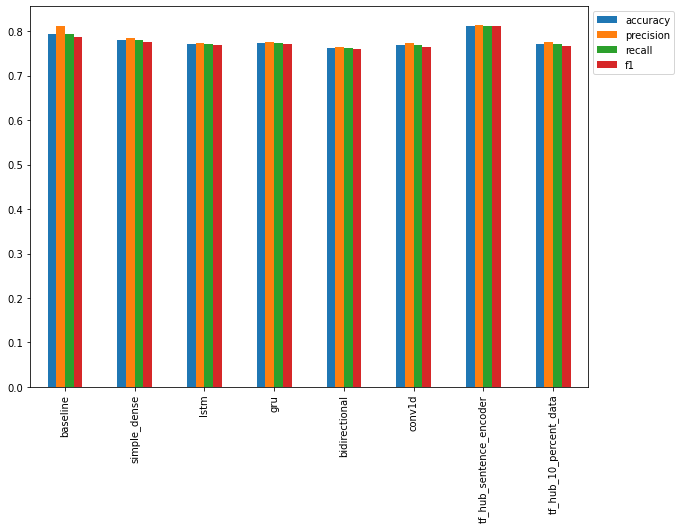

In [ ]:
# normalize accuracy and plot model results 
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

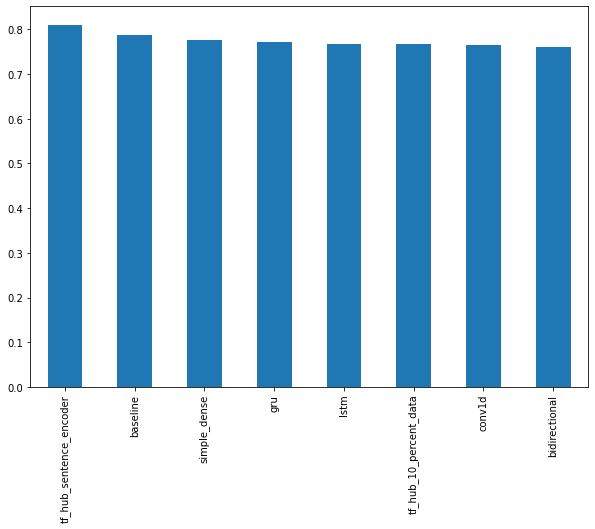

In [ ]:
# Sort model results by f1-score

all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

In [ ]:
# Create ensamble from models
# Combine baseline model, LSTM model, and USE model
# Average combined prediction of each

baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0.], dtype=float32)>

In [ ]:
ensemble_results= calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 79.13385826771653,
 'precision': 0.7910709758531173,
 'recall': 0.7913385826771654,
 'f1': 0.7910936404114438}

In [ ]:
# Add our combined model's results and calculate to the results
all_model_results.loc["ensemble_results"] = ensemble_results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.779528,0.784107,0.779528,0.776427
lstm,0.770341,0.772347,0.770341,0.768060
gru,0.772966,0.774516,0.772966,0.770970
bidirectional,0.762467,0.763531,0.762467,0.760510
conv1d,0.769029,0.773970,0.769029,0.765456
tf_hub_sentence_encoder,0.812336,0.814880,0.812336,0.810687
tf_hub_10_percent_data,0.770341,0.775563,0.770341,0.766706
ensemble_results,0.791339,0.791071,0.791339,0.791094
